# Analyzing Word Embeddings Learned by the LSTM Based Language Model
## LSTM Model Embedding Size 300, Hidden Size 300, Dropout 0.3

In [121]:
import os
import torch
import dill as pickle
import warnings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

In [97]:
def cosine_similarity(emb_matrix, device=torch.device('cpu')):
    """
    compute cosine similarity between tokens
    cosine similarity between vecs a and b = (a . b) / |a||b|
    
    :param emb_matrix: (torch.tensor) embedding matrix (vocab_size x emsize)
    :param device: device (default: cpu)
    :return: (torch.tensor) cosine similarity matrix (vocab_size x vocab_size)
    """
    
    with torch.no_grad():
        
        # transfer emb_matrix to device
        emb_matrix = emb_matrix.to(device)
            
        # compute magnitude of embedding vectors
        magnitudes = emb_matrix.pow(2).sum(dim=1).sqrt().unsqueeze(0)
        
        # compute denominators matrix
        denominators = torch.mm(magnitudes.t(), magnitudes)
        
        # compute cosine similarity matrix
        sim_matrix = torch.mm(emb_matrix, emb_matrix.t()) / denominators
        
    return sim_matrix

In [98]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [99]:
# load model
with open(os.path.join('models', 'lstm_emsize300_dropout0.3_tied.pt'),
          'rb') as f:
    model = torch.load(f, map_location=device)
print('model loaded')    

model loaded


In [100]:
# print model
print(model)

RNNModel(
  (drop): Dropout(p=0.3, inplace=False)
  (encoder): Embedding(33278, 300)
  (rnn): LSTM(300, 300, num_layers=2, dropout=0.3)
  (decoder): Linear(in_features=300, out_features=33278, bias=True)
)


In [101]:
cosine_sim_matrix = cosine_similarity(emb_matrix=model.encoder.weight, device=device)
print('computed cosine similarity matrix')

computed cosine similarity matrix


In [102]:
cosine_sim_matrix.shape

torch.Size([33278, 33278])

In [103]:
# load corpus
with open(os.path.join('data', 'wikitext-2', 'corpus.pkl'), 'rb') as f:
    corpus = pickle.load(f)

In [104]:
# get dictionary
dictionary = corpus.dictionary

assert len(dictionary) == len(cosine_sim_matrix)

In [107]:
words = [
    "while",
    "five",
    "some",
    "its",
    "I",
    "by", 
    "after",
    "with",
    "experience",
    "institute",
    "writers",
    "Paris",
    "engineering",
    "Bill",
    "not",
    "most",
    "American",
    "its",
    "four",
    "state",
    "operating",
    "BBC",
    "account",
    "accepted",
    "construction"
]

In [120]:
# closest and furthest words
for word in words:
    word_id = dictionary.word2idx[word]
    _, sim_word_ids = torch.topk(cosine_sim_matrix[word_id], 11)
    _, dissim_word_ids = torch.topk(-cosine_sim_matrix[word_id], 10)
    print(f'word: {word}')
    print('closest words: ', end='')
    for wid in sim_word_ids[1:]:
        print(f'{dictionary.idx2word[wid]} ', end='')
    print('\nfurthest words: ', end='')
    for wid in dissim_word_ids:
        print(f'{dictionary.idx2word[wid]} ', end='')
    print('\n')

word: while
closest words: although whilst whereas before when but after though despite if 
furthest words: Twentieth 19th- Trials Trans Pozières FROG Rushie ASTRA Welch Establishment 

word: five
closest words: three six four seven ten two eight nine sixteen thirteen 
furthest words: Claims Suggesting Listed Text opines Experiments chieftain surmised Bhopali translator 

word: some
closest words: many several any neither various much multiple numerous none both 
furthest words: Lounge Ladies Crab dolmen Pampas Associate ﻿ Gallimard Megastore Angels 

word: its
closest words: their his the her an a my our some several 
furthest words: Role quarrel However Consequently Nevertheless Except Essentially Unfortunately hitter admirer 

word: I
closest words: we We you You Who II never he [ What 
furthest words: contaminated dealings taxing embellished booking Oriental Terrence detecting Kilburn theologian 

word: by
closest words: from via under against when with through at after in 
furthes

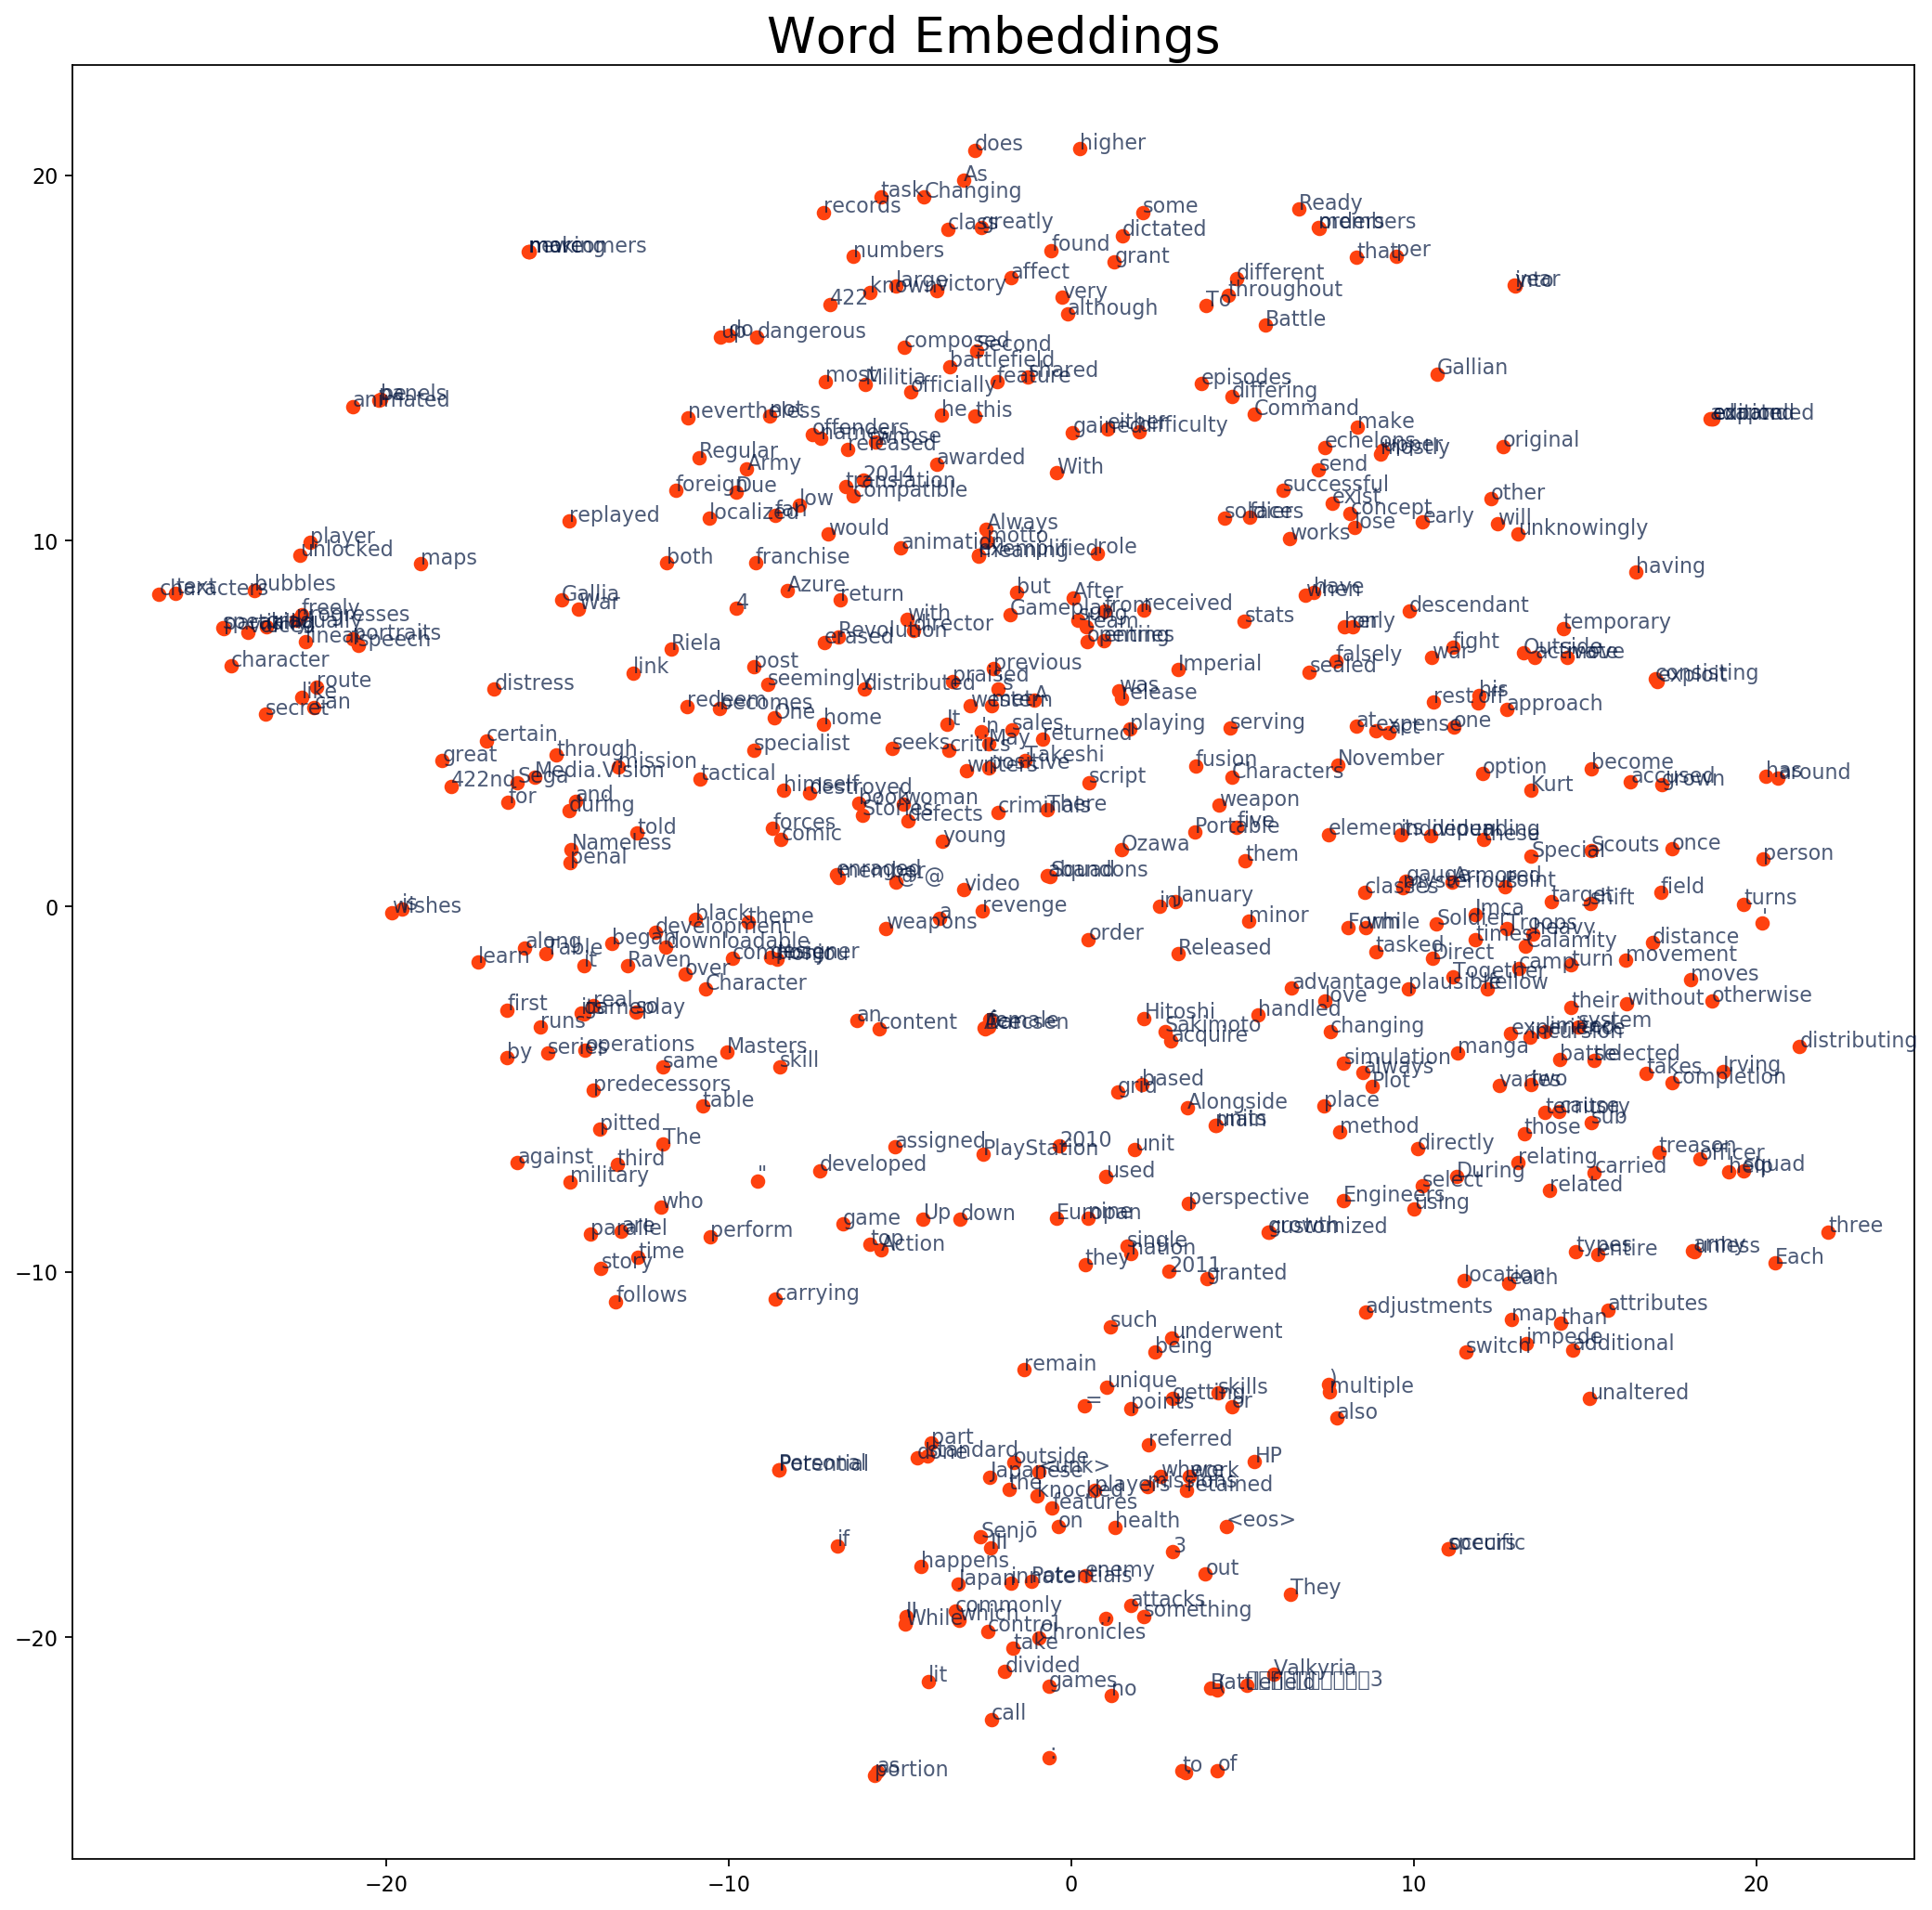

In [153]:
# TSNE
viz_words = 500
tsne = TSNE()
emb_tsne = tsne.fit_transform(model.encoder.weight.detach().cpu().numpy()[-viz_words:, :])

# plot
plt.figure(figsize=(16, 16), dpi=160)
for idx in range(viz_words):
    plt.scatter(*emb_tsne[idx, :], color='xkcd:orangered')
    plt.annotate(dictionary.idx2word[idx], (emb_tsne[idx, 0], emb_tsne[idx, 1]), alpha=0.7, color='xkcd:navy')

plt.title('Word Embeddings', fontsize=24)
plt.show()

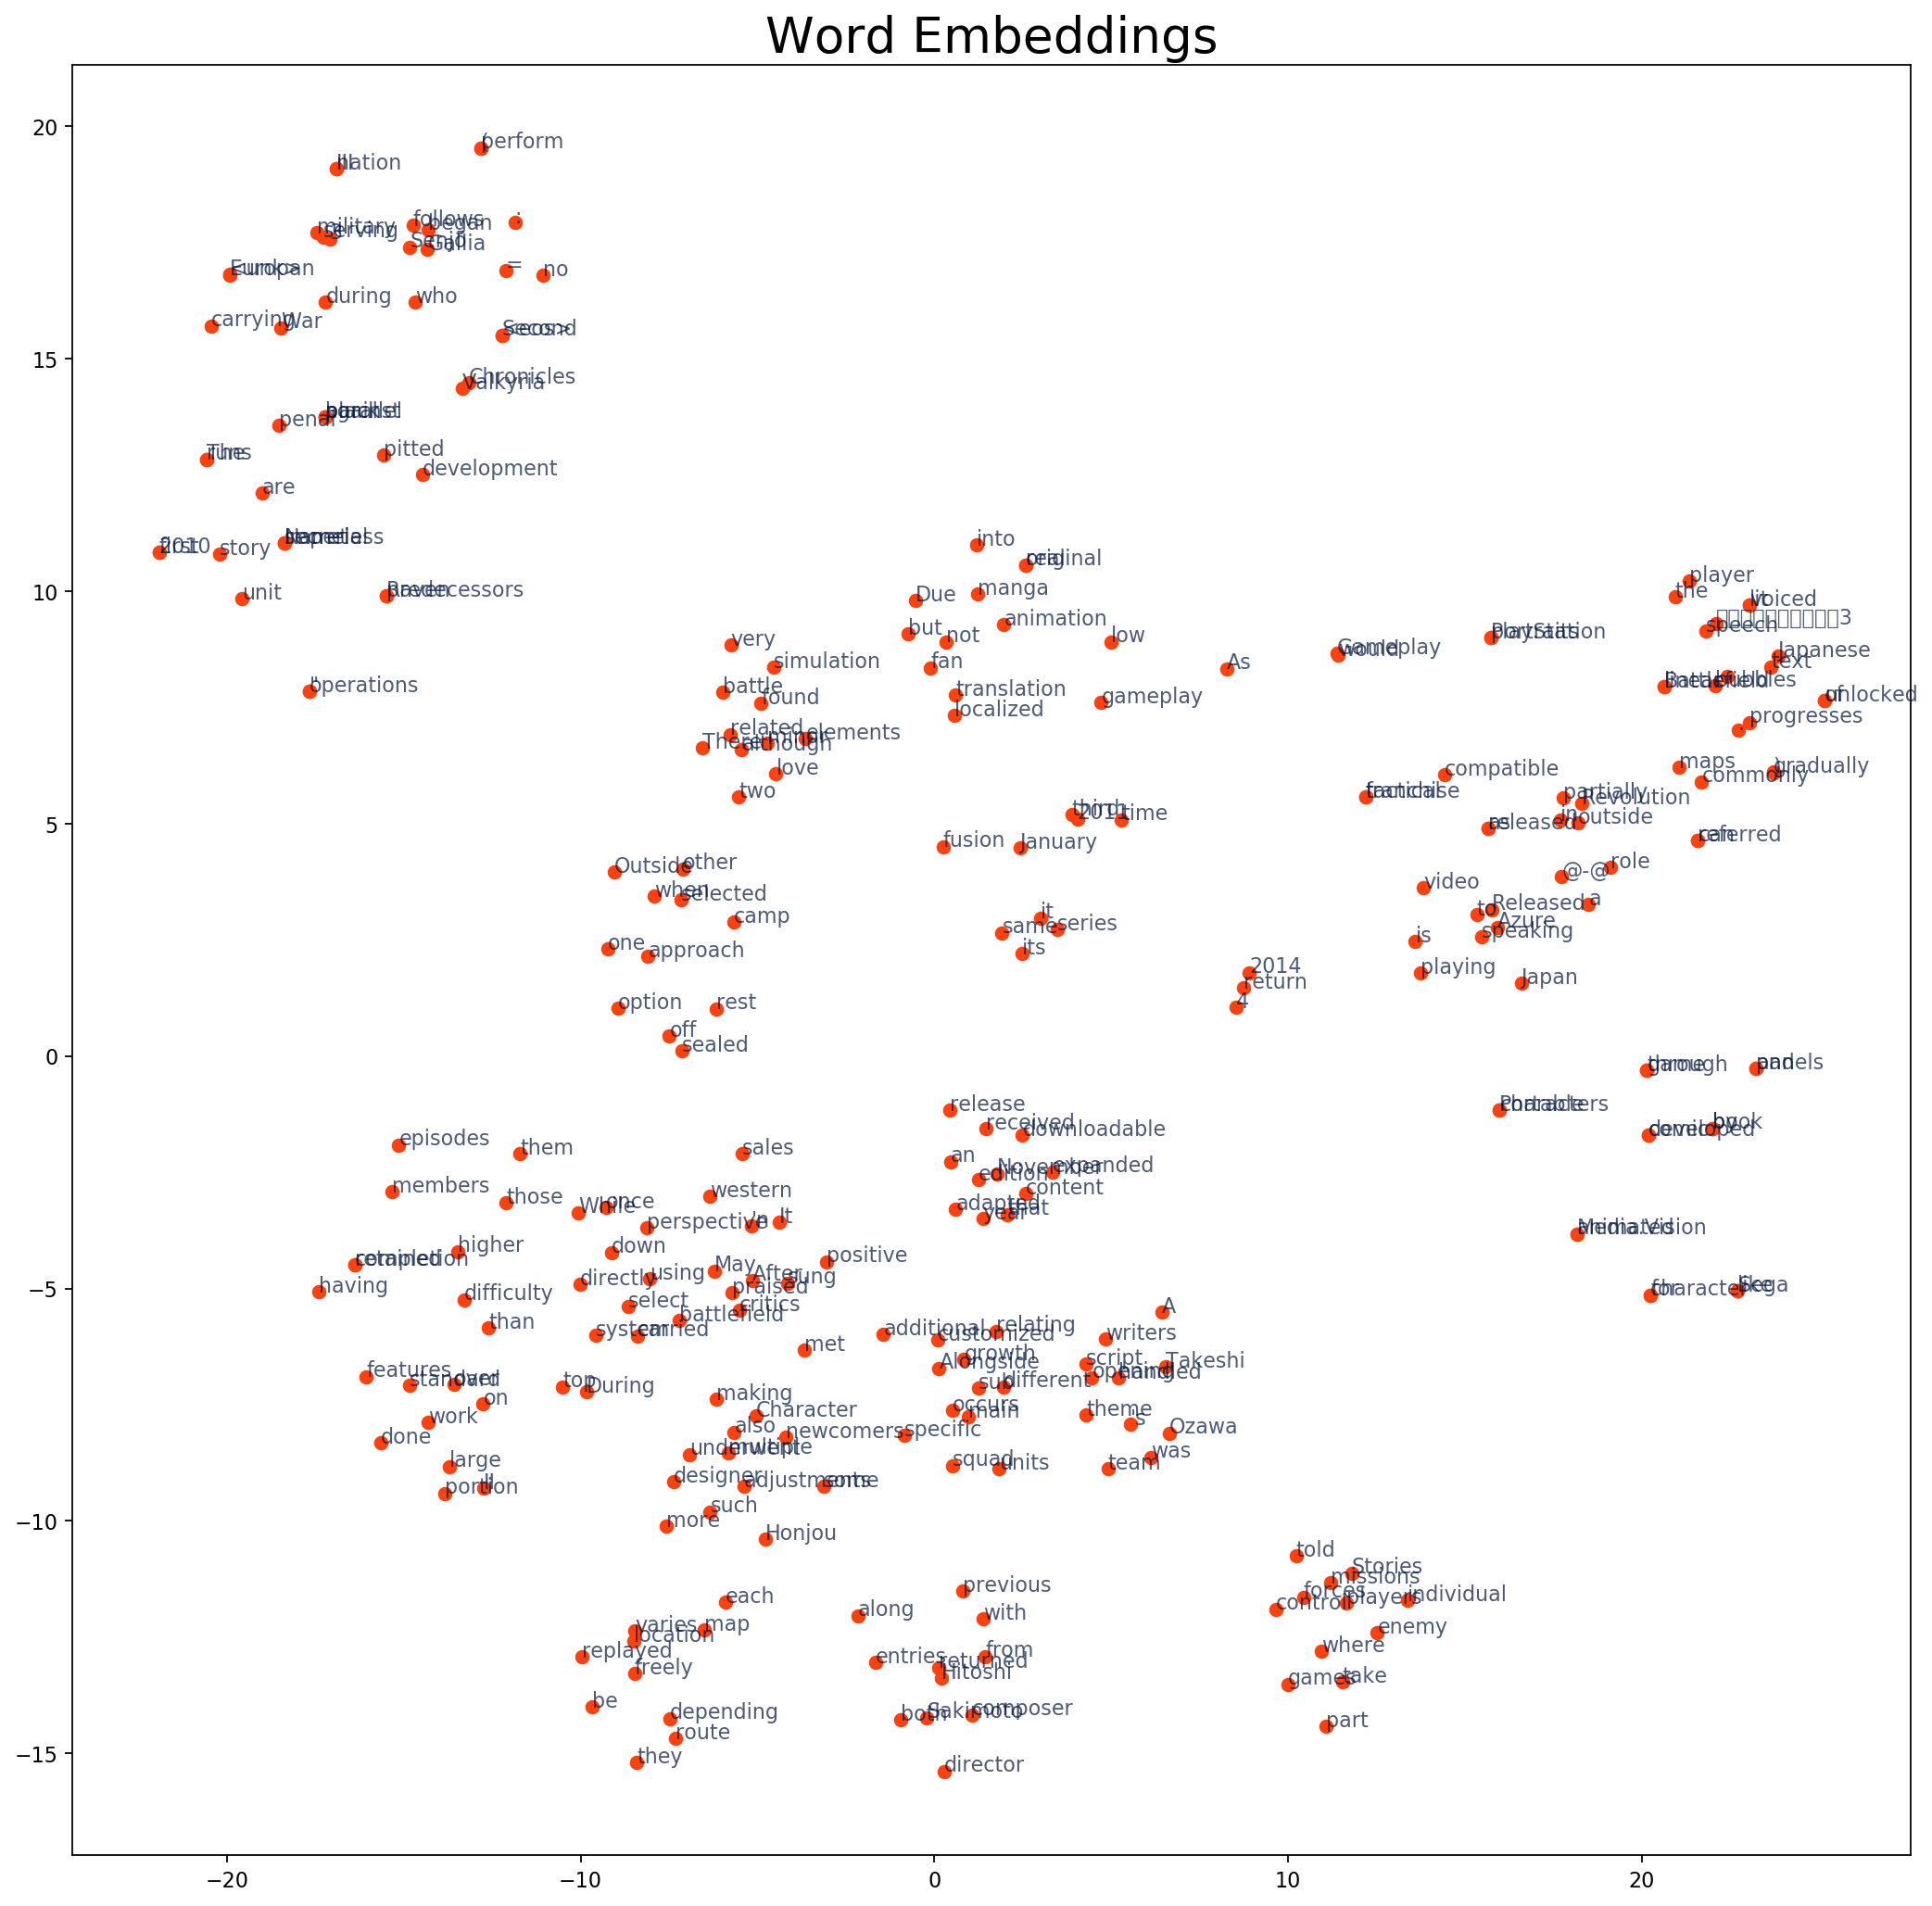

In [154]:
# selected words
word_ids = []
for word in words:
    word_id = dictionary.word2idx[word]
    _, sim_word_ids = torch.topk(cosine_sim_matrix[word_id], 11)
    word_ids.extend(sim_word_ids.tolist())

# TSNE
tsne = TSNE()
emb_tsne = tsne.fit_transform(model.encoder.weight.detach().cpu().numpy()[word_ids, :])

# plot
plt.figure(figsize=(16, 16), dpi=160)
for idx in range(len(word_ids)):
    plt.scatter(*emb_tsne[idx, :], color='xkcd:orangered')
    plt.annotate(dictionary.idx2word[idx], (emb_tsne[idx, 0], emb_tsne[idx, 1]), alpha=0.7, color='xkcd:navy')

plt.title('Word Embeddings', fontsize=24)
plt.show()